In [1]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from modin.config import ProgressBar
from tqdm import tqdm

# import seaborn as sns

ProgressBar.enable()

In [2]:
df = (
    pd.read_parquet("wforms-occ.parquet", columns=["fst", "lst", "tot", "rho"])
    .add_suffix("_occ")
    .join(
        pd.read_parquet("wforms-usr.parquet", columns=["tot", "rho"]).add_suffix("_usr")
    )
)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-29 12:59:40,705	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [3]:
ft = (df["fst_occ"] > 7) & (df["lst_occ"] > 354) & (df["lst_occ"] - df["fst_occ"] > 28)
fc = (df["tot_usr"] > 9) & (df["tot_occ"] > 9)
fg = df["rho_occ"].gt(0.2)
fa = abs(df["rho_occ"]).gt(0.2) | abs(df["rho_usr"]).gt(0.2)

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 116:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 118:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 164:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 165:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 213:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 214:   0%           Elapsed time: 00:00, estimated remaining time: ?

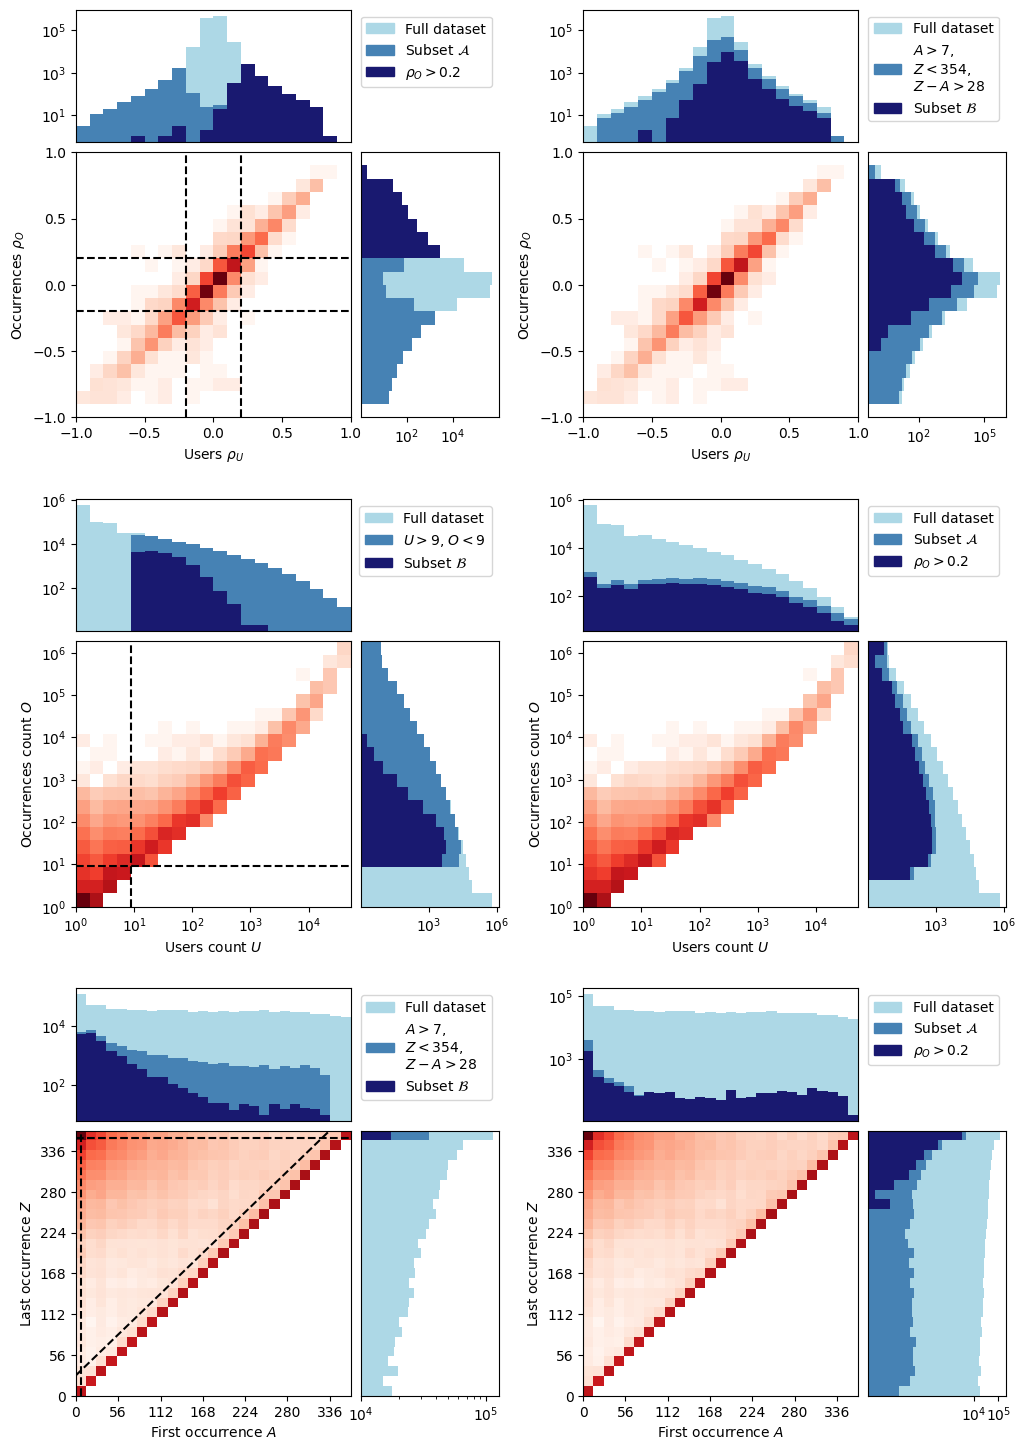

In [5]:
style_line = {"color": "k", "linestyle": "--"}
style_hist = {"cmap": "Reds"}
style_marg = {"log": True, "align": "mid"}
s_gridspec = {
    "width_ratios": (4, 2),
    "height_ratios": (2, 4),
    "wspace": 0.05,
    "hspace": 0.05,
}
tick_margx = {
    "axis": "x",
    "which": "both",
    "bottom": False,
    "top": False,
    "labelbottom": False,
}
tick_margy = {
    "axis": "y",
    "which": "both",
    "left": False,
    "right": False,
    "labelleft": False,
}
marg_cols = ["lightblue", "steelblue", "midnightblue"]

fig = plt.figure(figsize=(6 * 2, 6 * 3))

ggs = gridspec.GridSpec(
    3,
    2,
    width_ratios=(1, 1),
    height_ratios=(1, 1, 1),
    wspace=0.2,
    hspace=0.2,
    figure=fig,
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[0, 0])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    df["rho_usr"], df["rho_occ"], bins=np.linspace(-1, 1, 20 + 1)
)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax_hist2d.axvline(x=+0.2, **style_line)
ax_hist2d.axvline(x=-0.2, **style_line)
ax_hist2d.axhline(y=+0.2, **style_line)
ax_hist2d.axhline(y=-0.2, **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(df["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(df[fa]["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df[fa]["rho_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(df[fg]["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df[fg]["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

ax_hist2d.set_xlim((-1, 1))
ax_hist2d.set_ylim((-1, 1))

ax_hist2d.set_xticks(np.linspace(-1, 1, 5))
ax_hist2d.set_yticks(np.linspace(-1, 1, 5))

ax_hist2d.set_xlabel("Users $\\rho_U$")
ax_hist2d.set_ylabel("Occurrences $\\rho_O$")

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="Subset $\mathcal{A}$"),
        mpatches.Patch(color=marg_cols[2], label="$\\rho_O>0.2$"),
    ],
    loc="upper right",
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[1, 0])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    np.log10(df["tot_usr"]), np.log10(df["tot_occ"]), bins=20
)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax_hist2d.axvline(x=np.log10(9), **style_line)
ax_hist2d.axhline(y=np.log10(9), **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(np.log10(df["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(np.log10(df["tot_occ"]), bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(np.log10(df[fc]["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(
    np.log10(df[fc]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(np.log10(df[fc & ft]["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(
    np.log10(df[fc & ft]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(True)

formatter = FuncFormatter(lambda value, tick_number: f"$10^{value:.0f}$")
ax_hist2d.xaxis.set_major_formatter(formatter)
ax_hist2d.yaxis.set_major_formatter(formatter)
ax_hist2d.set_xlabel("Users count $U$")
ax_hist2d.set_ylabel("Occurrences count $O$")

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="$U>9$, $O<9$"),
        mpatches.Patch(color=marg_cols[2], label="Subset $\mathcal{B}$"),
    ],
    loc="upper right",
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[2, 0])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(df["fst_occ"], df["lst_occ"], bins=55 // 2)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax_hist2d.axvline(x=7, **style_line)
ax_hist2d.axhline(y=354, **style_line)
ax_hist2d.axline((0, 28), slope=1, **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(df["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(df[ft]["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df[ft]["lst_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(df[ft & fc]["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df[ft & fc]["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

ax_hist2d.set_xlim((0, 364))
ax_hist2d.set_ylim((0, 364))

ax_hist2d.set_xticks(np.arange(0, 364, 7 * 8))
ax_hist2d.set_yticks(np.arange(0, 364, 7 * 8))

ax_hist2d.set_xlabel("First occurrence $A$")
ax_hist2d.set_ylabel("Last occurrence $Z$")

ax_marg_y.set_xticks([10**4, 10**5])

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="$A>7$,\n$Z<354$,\n$Z-A>28$"),
        mpatches.Patch(color=marg_cols[2], label="Subset $\mathcal{B}$"),
    ],
    loc="upper right",
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[0, 1])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    df["rho_usr"], df["rho_occ"], bins=np.linspace(-1, 1, 20 + 1)
)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(df["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(df[fc]["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df[fc]["rho_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(df[fc & ft]["rho_usr"], bins=xedges, **style)
ax_marg_y.hist(df[fc & ft]["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

ax_hist2d.set_xlim((-1, 1))
ax_hist2d.set_ylim((-1, 1))

ax_hist2d.set_xticks(np.linspace(-1, 1, 5))
ax_hist2d.set_yticks(np.linspace(-1, 1, 5))

ax_hist2d.set_xlabel("Users $\\rho_U$")
ax_hist2d.set_ylabel("Occurrences $\\rho_O$")

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="$A>7$,\n$Z<354$,\n$Z-A>28$"),
        mpatches.Patch(color=marg_cols[2], label="Subset $\mathcal{B}$"),
    ],
    loc="upper right",
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[1, 1])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    np.log10(df["tot_usr"]), np.log10(df["tot_occ"]), bins=20
)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(np.log10(df["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(np.log10(df["tot_occ"]), bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(np.log10(df[fa]["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(
    np.log10(df[fa]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(np.log10(df[fg]["tot_usr"]), bins=xedges, **style)
ax_marg_y.hist(
    np.log10(df[fg]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(True)

formatter = FuncFormatter(lambda value, tick_number: f"$10^{value:.0f}$")
ax_hist2d.xaxis.set_major_formatter(formatter)
ax_hist2d.yaxis.set_major_formatter(formatter)
ax_hist2d.set_xlabel("Users count $U$")
ax_hist2d.set_ylabel("Occurrences count $O$")

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="Subset $\mathcal{A}$"),
        mpatches.Patch(color=marg_cols[2], label="$\\rho_O>0.2$"),
    ],
    loc="upper right",
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[2, 1])
ax_hist2d = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_hist2d)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_hist2d)
ax_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(df["fst_occ"], df["lst_occ"], bins=55 // 2)
ax_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax_marg_x.hist(df["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax_marg_x.hist(df[fa]["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df[fa]["lst_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax_marg_x.hist(df[fg]["fst_occ"], bins=xedges, **style)
ax_marg_y.hist(df[fg]["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

ax_hist2d.set_xlim((0, 364))
ax_hist2d.set_ylim((0, 364))

ax_hist2d.set_xticks(np.arange(0, 364, 7 * 8))
ax_hist2d.set_yticks(np.arange(0, 364, 7 * 8))

ax_hist2d.set_xlabel("First occurrence $A$")
ax_hist2d.set_ylabel("Last occurrence $Z$")

ax_marg_y.set_xticks([10**4, 10**5])

ax_marg_x.tick_params(**tick_margx)
ax_marg_y.tick_params(**tick_margy)

ax_legend.axis("off")
ax_legend.legend(
    handles=[
        mpatches.Patch(color=marg_cols[0], label="Full dataset"),
        mpatches.Patch(color=marg_cols[1], label="Subset $\mathcal{A}$"),
        mpatches.Patch(color=marg_cols[2], label="$\\rho_O>0.2$"),
    ],
    loc="upper right",
)

# ===============================================================================

plt.savefig("subsets.pdf", format="pdf", bbox_inches="tight")
plt.show()